In [1]:
def m2tex(model,modelName):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: {} \\\\ \hline".format(modelName)
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] += " \hline"
    stringlist[-3] += " \\\\"
    stringlist[-2] += " \\\\"
    stringlist[-1] += " \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{{Model summary for {}.}}".format(modelName), "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)


In [2]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import *
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize"] = (20,10)


## Import Data


In [3]:
X = pd.read_csv("../Baseline/data_UE2_600/X_600_TTI.csv", index_col=0)
y = pd.read_csv("../Baseline/data_UE2_600/y_600_TTI.csv", index_col=0)



In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=False)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(354, 1280)
(354, 3840)
(236, 1280)
(236, 3840)


In [6]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [7]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)

## Create a sampling layer


In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder


In [9]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLU = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(350, activation=ReLU)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 350)          448350      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 100)          35100       ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 100)          35100       ['dense[0][0]']                  
                                                                                            

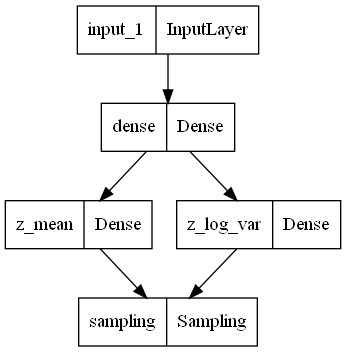

In [10]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(300,  activation=ReLU)(latent_inputs)
decoder_outputs = layers.Dense(input_dim * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 300)               30300     
                                                                 
 dense_2 (Dense)             (None, 3840)              1155840   
                                                                 
Total params: 1,186,140
Trainable params: 1,186,140
Non-trainable params: 0
_________________________________________________________________


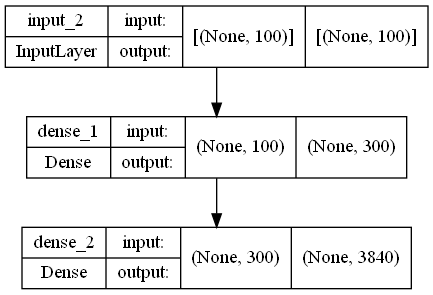

In [12]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [14]:
vae = VAE(encoder, decoder)

In [15]:
vae.compile(optimizer=keras.optimizers.Adam())

In [16]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [17]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc, y_test), epochs=50, batch_size=10)#, callbacks=es)

Epoch 1/50
36/36 [==============================] - 1s 16ms/step - loss: 58.9408 - MSE: 0.0588 - kl_loss: 43.7883 - val_loss_val: 49.7897 - val_MSE_val: 0.0513 - val_kl_loss_val: 49.7147
Epoch 2/50
36/36 [==============================] - 0s 10ms/step - loss: 17.2088 - MSE: 0.0373 - kl_loss: 16.1243 - val_loss_val: 40.4610 - val_MSE_val: 0.0422 - val_kl_loss_val: 40.4469
Epoch 3/50
36/36 [==============================] - 0s 10ms/step - loss: 9.1208 - MSE: 0.0328 - kl_loss: 8.7383 - val_loss_val: 36.8515 - val_MSE_val: 0.0385 - val_kl_loss_val: 36.8474
Epoch 4/50
36/36 [==============================] - 0s 10ms/step - loss: 5.7876 - MSE: 0.0311 - kl_loss: 5.7198 - val_loss_val: 34.2042 - val_MSE_val: 0.0366 - val_kl_loss_val: 34.1982
Epoch 5/50
36/36 [==============================] - 0s 9ms/step - loss: 4.1568 - MSE: 0.0300 - kl_loss: 4.1043 - val_loss_val: 31.8031 - val_MSE_val: 0.0353 - val_kl_loss_val: 31.8042
Epoch 6/50
36/36 [==============================] - 0s 9ms/step - loss: 

36/36 [==============================] - 0s 11ms/step - loss: 0.2898 - MSE: 0.0267 - kl_loss: 0.2696 - val_loss_val: 10.0968 - val_MSE_val: 0.0306 - val_kl_loss_val: 10.0943
Epoch 46/50
36/36 [==============================] - 0s 12ms/step - loss: 0.3104 - MSE: 0.0267 - kl_loss: 0.2696 - val_loss_val: 9.9448 - val_MSE_val: 0.0306 - val_kl_loss_val: 9.9430
Epoch 47/50
36/36 [==============================] - 0s 12ms/step - loss: 0.2896 - MSE: 0.0267 - kl_loss: 0.2575 - val_loss_val: 9.7720 - val_MSE_val: 0.0305 - val_kl_loss_val: 9.7669
Epoch 48/50
36/36 [==============================] - 0s 11ms/step - loss: 0.3226 - MSE: 0.0266 - kl_loss: 0.2733 - val_loss_val: 9.5731 - val_MSE_val: 0.0307 - val_kl_loss_val: 9.5635
Epoch 49/50
36/36 [==============================] - 0s 12ms/step - loss: 0.2656 - MSE: 0.0267 - kl_loss: 0.2445 - val_loss_val: 9.3663 - val_MSE_val: 0.0306 - val_kl_loss_val: 9.3607
Epoch 50/50
36/36 [==============================] - 0s 11ms/step - loss: 0.2584 - MSE: 0.

In [18]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


In [19]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 1.0067296961258332
MAE 16.7141697114037
RMSE 2.684731843670129
MSE 7.212472513081149


# 

# PLOTS


In [20]:
samp_num = 1

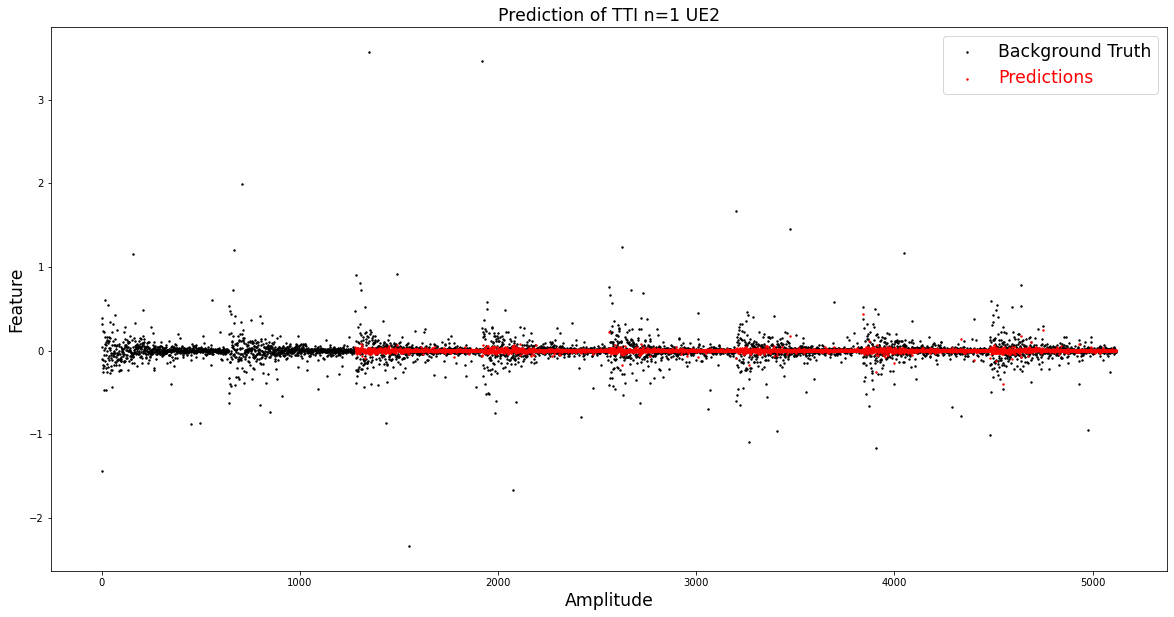

In [21]:
sample_1 = np.r_[ y_test[samp_num,], X_test[samp_num,]]
idx = np.arange(len(sample_1))
plt.scatter(np.arange(len(sample_1)), sample_1, s=2, c="black")
plt.scatter(idx[-len(vae.predict(X_test)[samp_num,]):], vae.predict(X_test)[samp_num,], color='red',  s=2)
plt.title('Prediction of TTI n={} UE2'.format(samp_num) , fontsize ='xx-large')
plt.legend(['Background Truth', 'Predictions'],labelcolor = ['black', 'red'] ,loc='upper right', fontsize ='xx-large')
plt.ylabel('Feature', fontsize ='xx-large')
plt.xlabel('Amplitude', fontsize ='xx-large')

plt.show()

In [22]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


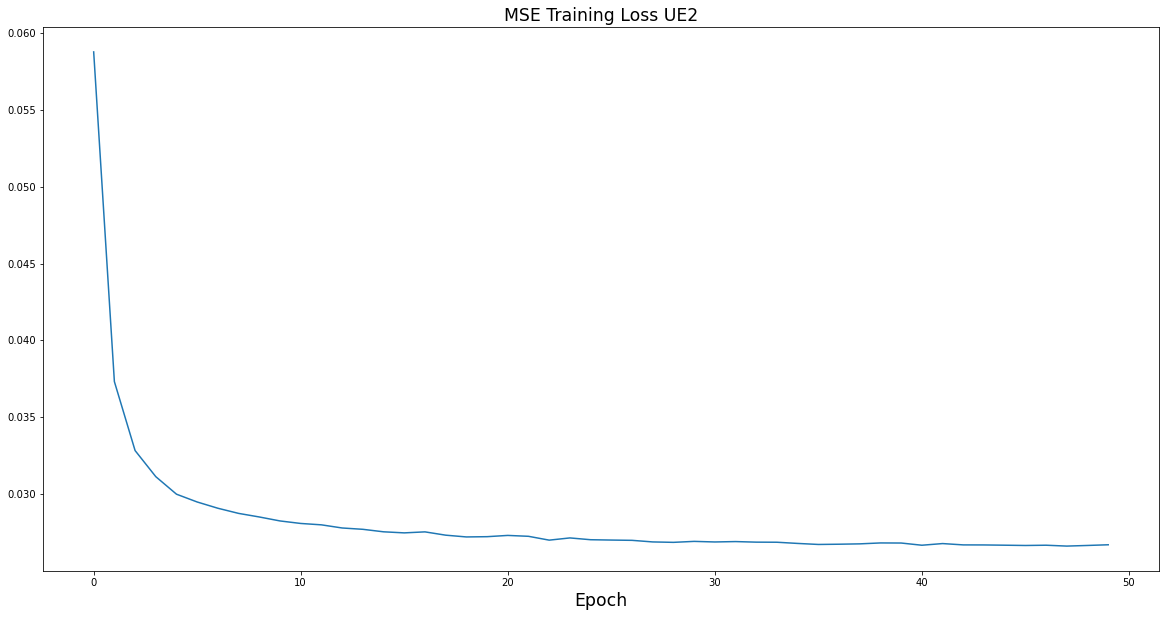

In [23]:
plt.plot(history.history['MSE'])
plt.title('MSE Training Loss UE2', fontsize ='xx-large')
plt.xlabel('Epoch', fontsize ='xx-large')
plt.show()

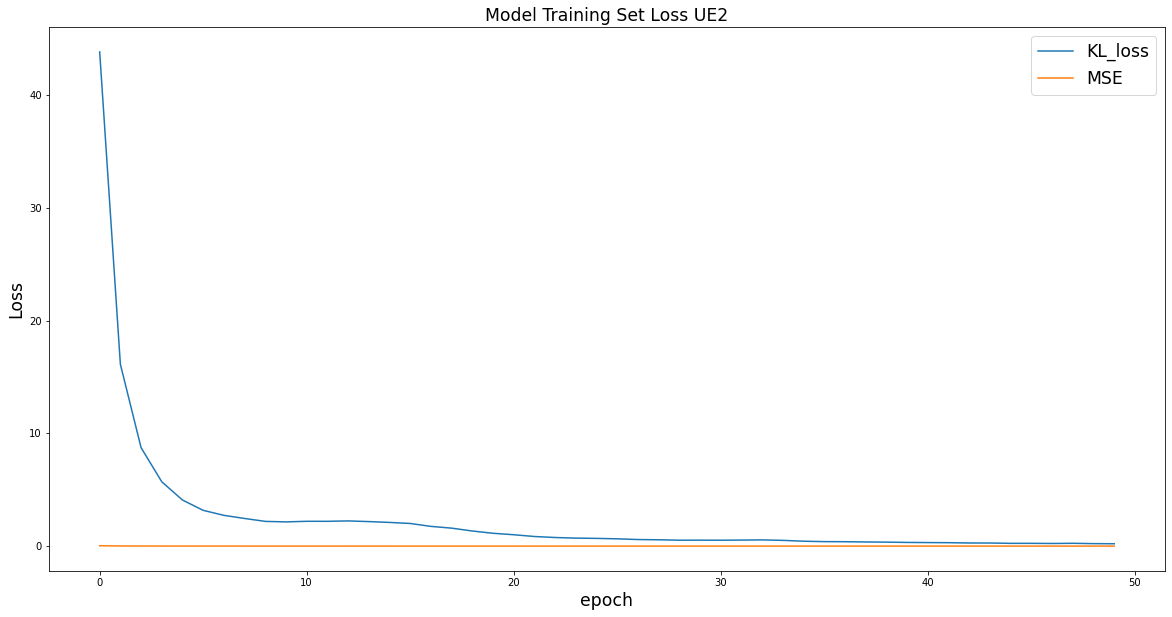

In [24]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('Model Training Set Loss UE2', fontsize ='xx-large')
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


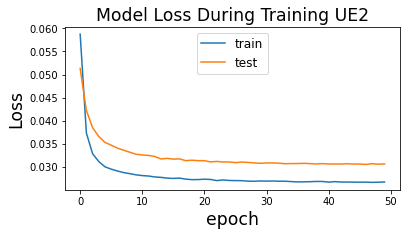

In [25]:
# summarize history for accuracy
plt_1 = plt.figure(figsize=(6, 3))

plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper center', fontsize ='12')
plt.title('Model Loss During Training UE2', fontsize='xx-large')

plt.show()


In [26]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 1.0038704604382889
MAE 16.684803386035007
RMSE 2.683240174396338
MSE 7.201283386507612


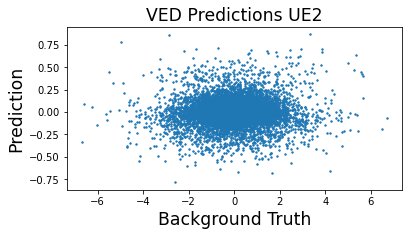

In [27]:
plt_1 = plt.figure(figsize=(6, 3))
plt.scatter(y_test.flatten(), vae.predict(X_test_esc).flatten(), s=2)
plt.title('VED Predictions UE2', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')

plt.show()

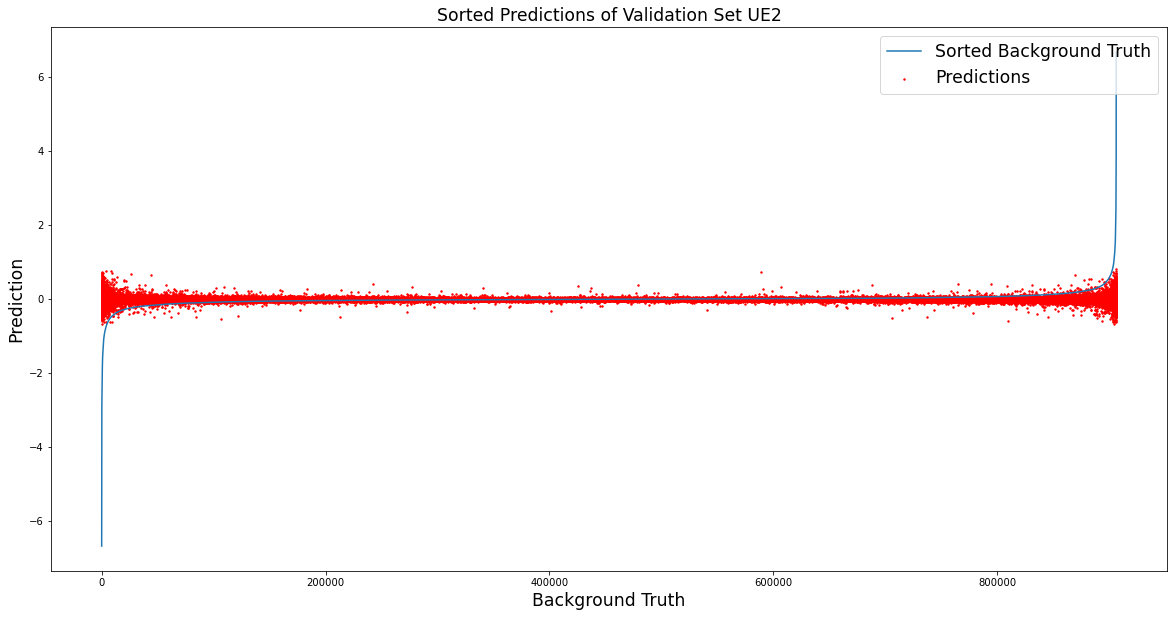

In [28]:
plt.plot(np.sort(y_test.flatten()))

x_idx = np.arange(len(y_test.flatten()))
plt.scatter(x_idx, vae.predict(X_test_esc).flatten()[np.argsort(y_test.flatten())], s=2, c="red")

plt.title('Sorted Predictions of Validation Set UE2', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')
plt.legend(['Sorted Background Truth', 'Predictions'], loc='upper right', fontsize ='xx-large')

plt.show()


# 

# Modeling

In [29]:
import scipy

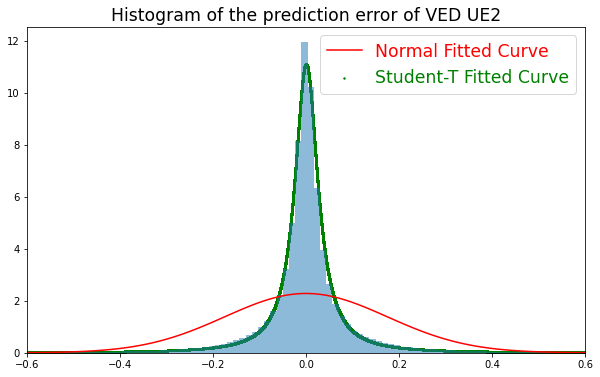

In [30]:
plt_1 = plt.figure(figsize=(10, 6))

# Error to be fitted
data = y_test.flatten() - vae.predict(X_test_esc).flatten()

# Fit of Normal Distribution
_, bins, _ = plt.hist(data, 1000, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(data)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)


# Fit of Student-t
param = scipy.stats.t.fit(data)
pdf_fitted = scipy.stats.t.pdf(data, loc=param[1], scale=param[2], df=param[0])

plt.title('Histogram of the prediction error of VED UE2', fontsize='xx-large')
plt.plot(bins, best_fit_line, c='red')
plt.scatter(data, pdf_fitted, s=2, c='green')
plt.legend(['Normal Fitted Curve', 'Student-T Fitted Curve'],labelcolor = ['red', 'green'],  loc='upper right', fontsize ='xx-large')
plt.xlim([-0.6, 0.6])

plt.show()

## LaTeX

In [31]:
m2tex(encoder, 'encoder')

\begin{table}[] 
\begin{tabular}{lll} 
Model: encoder \\ \hline 
 Layer (type)          Output S& hape   Param   Connected to &            \\ \hline \hline 
===============================& ============================& ===========\\ \hline 
                       ]       &                             &            \\ \hline 
 dense (Dense)         (None, 3& 50)    448350  ['input\_1[0][& 0]']       \\ \hline 
 z\_mean (Dense)        (None, 1& 00)    35100   ['dense[0][0]& ']         \\ \hline 
 z\_log\_var (Dense)     (None, 1& 00)    35100   ['dense[0][0]& ']         \\ \hline 
 sampling (Sampling)   (None, 1& 00)    0       ['z\_mean[0][0& ]',        \\ \hline 
                               &                             &            \\ \hline \hline 
Total params: 518,550 \\ 
Trainable params: 518,550 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for encoder.} 
\label{tab:model-summary} 
\end{table}


In [32]:
m2tex(decoder, 'decoder')

\begin{table}[] 
\begin{tabular}{lll} 
Model: decoder \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 input\_2 (InputLayer)          & [(None, 100)]               & 0          \\ \hline 
 dense\_1 (Dense)               & (None, 300)                 & 30300      \\ \hline 
 dense\_2 (Dense)               & (None, 3840)                & 1155840    \\ \hline 
===============================& ============================& ===========\\ \hline \hline 
Total params: 1,186,140 \\ 
Trainable params: 1,186,140 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for decoder.} 
\label{tab:model-summary} 
\end{table}
